In [1]:
#The code I used to generate example data 
# M = np.zeros((300, 4))
# K = np.load(namefile(2,3))
# for i in range(300):
#     M[i,0] = np.random.randint(low = 0, high = Ntimes)
#     M[i,1] = np.random.randint(low = 0, high = N)
#     M[i,2] = np.random.randint(low = 0, high = N)
#     M[i,3] = K[int(M[i,0]),int(M[i,1]),int(M[i,2])]
# M = np.unique(M, axis = 0)
#np.save('Example_data.npy', M)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm as t
from pathlib import Path
from run_forward_model import generate_model_config, run_model, create_grid

# Fetch simulation data path
namefile = lambda i,j: Path().cwd() / f'data/sample_data_{i}_{j}.npy'



In [3]:
# Loading true data
measurement_data_file = "../data/pm25_processed_1day.npy"
measurement_array = np.load(measurement_data_file)
sorted_array = np.array(sorted(measurement_array, key = lambda x: (x[0], x[1], x[2])))
if (sorted_array != measurement_array).any():
    measurement_array = sorted_array
    print("Measurement array sorted")
tmp, ar = np.unique(measurement_array[:,0:3], axis=0, return_index=True)
measurement_array = measurement_array[ar,:]

Measurement array sorted


In [5]:
# Generate forward model data

#Parameters of the grid
tmax = 600*145
time_step = 600
Nx = Ny = 80
widthx = 110e3
widthy = 220e3
# Model parameters
source_strength = np.array([1.0])
source_locations = np.array([[60, 60]])
velocity_field = np.array([-4.0, -6.0])
diffusion_coefficent = 10.0
sensor_times = np.arange(0, tmax, step=600)
Ntimes = len(sensor_times)
# Model config
gb = create_grid(Nx, widthx, Ny, widthy)
model_grid = gb.get_grids()[0]


In [6]:
cell_widthx = widthx / Nx
cell_widthy = widthy / Ny

In [7]:
""" 
DO NOT RUN IF DATA ALREADY EXISTS
"""
for i in range(Nx*Ny):
    source_location = np.atleast_2d(model_grid.cell_centers[:2,i])
    config = generate_model_config(
        Nx = Nx, Ny = Ny,
        widthx = widthx, widthy = widthy,
        time_step = time_step, tmax = tmax,
        source_strength = source_strength,
        source_locations = source_location,
        velocity_field = velocity_field,
        diffusion_coefficent = diffusion_coefficent,
        sensor_times = sensor_times,
    )
    true_data, gb_true = run_model(
        config, save_output=True,
        # coarsegrain_output=True, coarse_grid=model_grid,
        # create_gif=True
    )
    if (i % Nx) == 0:
        print('finished sim ',i,' out of ',Nx*Ny)

finished sim  0  out of  6400
finished sim  80  out of  6400


KeyboardInterrupt: 

In [8]:
np.isclose(measurement_array[:,0], 6)
sensors_at_t = measurement_array[np.isclose(measurement_array[:,0], 6),:]
sensor_locs = (sensors_at_t[:,[1,2]] * np.array([cell_widthx, cell_widthy]) + np.array([cell_widthx, cell_widthy]) / 2).T
model_grid.closest_cell(sensor_locs)

array([5689, 5291, 4336, 3860, 3541, 3623, 3703, 4183, 5143, 3224, 3544,
       2666, 3786, 3068, 3468, 2989, 1950, 3470, 2192, 2592, 2355, 3796,
       3637, 4517, 1558, 4758, 5079, 5479, 3400, 3242,  364, 4124,  125,
         46, 2128, 3008, 2533, 2376, 2377, 1738, 1499, 3825, 3427, 3116,
        158])

In [9]:
def weighted_norm(Sigma_inv, x):
    return x.T@Sigma_inv@x

def compute_posterior(prior, measurement_array, sigma, scaling=1.0, preload_sim_data=None):

    if preload_sim_data is None:
        #Will load the matrices from disk
        #I build the mask first
        measurement_mask = np.zeros((Ntimes, Nx, Ny)).astype(bool)
        for i in range(len(measurement_array)):
            measurement_mask[int(measurement_array[i,0]), int(measurement_array[i,1]), int(measurement_array[i,2])] = True
        get_hypothetical = lambda i,j: np.load(namefile(i,j)).reshape(Ntimes,Nx,Ny)[measurement_mask]
    else:
        #preload_sim_data has to be (N,N,N_measurements)
        get_hypothetical = lambda i,j: preload_sim_data[i,j]
    
    data = measurement_array[:, -1] 
    
    #Sigma_inv = np.linalg.inv(Sigma_noise)
    posterior = np.zeros((Nx,Ny))
    #I'm not sure if this can be vectorized more since I have to individually open and close files
    for i in t(range(Nx)):
        for j in range(Ny):
            #Compute prob(data|source is in (i,j))
            #Compute first true observations that would have happened if the source was in (i,j)
            hypothetical_observations = get_hypothetical(i,j)
            scaling = np.mean(data)/np.mean(hypothetical_observations)
            hypothetical_observations *= scaling
            #posterior[i,j] = prior[i,j]*np.exp(-1/2 * weighted_norm(Sigma_inv, data-hypothetical_observations))
            posterior[i,j] = prior[i,j]*np.exp((-1/(2 * sigma**2) * np.linalg.norm(data-hypothetical_observations)**2))
    s = np.sum(posterior)
    posterior/= s
    return posterior

In [12]:
#Example uniform prior
prior = 1/Nx/Ny * np.ones((Nx,Ny))

In [11]:
# Prior that doesn't allow ocean
prior = np.ones((Nx,Ny))
for i in range(Nx):
    for j in range(Ny):
        if j < (80 - 2*i):
            prior[j,i] = 0
s = np.sum(prior)
prior /= s

In [23]:
#How much noise do we assume that the measurements had? In units of the measurements
#Assuming here that all the sensors are independent and with the same noise
n_measurements = measurement_array.shape[0]
sigma = 1.0
Sigma_noise = sigma**2*np.eye(n_measurements) 

# Scale the theoretical data
x = 40
y = 40
measurement_mask = np.zeros((Ntimes, Nx, Ny)).astype(bool)
for i in range(len(measurement_array)):
    measurement_mask[int(measurement_array[i,0]), int(measurement_array[i,1]), int(measurement_array[i,2])] = True
get_hypothetical = lambda i,j: np.load(namefile(i,j)).reshape(Ntimes,Nx,Ny)[measurement_mask]

hypothetical_observations = get_hypothetical(x,y)
data = measurement_array[:, -1] 
scaling = np.mean(data)/np.mean(hypothetical_observations)

In [24]:
posterior = compute_posterior(prior = prior, measurement_array=measurement_array, sigma=sigma, scaling=scaling)

  0%|          | 0/80 [00:00<?, ?it/s]

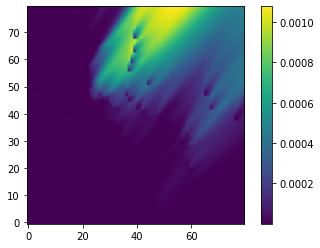

In [25]:
import matplotlib.pyplot as plt
casename = "case_runs/80x80_realdata_scaled_sigma1_0"
plt.imshow(posterior)
plt.colorbar()
plt.gca().invert_yaxis()
plt.savefig(casename + ".png")
np.save(casename + ".npy", posterior)

## Plotting
!! Weird issue with Emily's environment and cartopy; separate notebook exists in case_runs
folder for this if you have same issue

In [24]:
import cartopy.crs as ccrs

lat_s = 35.0
lat_n = 40.0
lon_e = -118.0
lon_w = -124.0

xy_list = np.load('../data/pm25_xy_list.npy')

def map_coords_to_grid(coords_tuple, elt= 'both', grid_size=80, lat = [lat_s,lat_n], lon = [lon_w,lon_e]):
    '''
    takes in tuple of (lat,lon) in degrees and maps it to values b/w 0 and 1 that fit on discretized 80**2 grid.
    use for source location and sensor mappings
    '''
    lat_deg = coords_tuple[1]
    lon_deg = coords_tuple[0]

    #convert to 80sq grid
    lat_grid = (lat_deg - lat[0])/(lat[1]-lat[0])*grid_size
    lon_grid = (lon_deg - lon[0])/(lon[1] - lon[0])*grid_size

    #round so div to 80, get to [0,1] range
    lat_grid_01 = round(lat_grid)#/grid_size
    lon_grid_01 = round(lon_grid)#/grid_size
    if elt == 'lat':
        return lat_grid_01
    elif elt == 'lon':
        return lon_grid_01
    else:
        return lon_grid_01, lat_grid_01            

def map_grid_to_coords(coords_tuple, elt='both', grid_size=80, lat= [lat_s, lat_n], lon = [lon_w,lon_e]):
    lat_ind = coords_tuple[1]
    lon_ind = coords_tuple[0]

    #convert to lat/lon
    lat_grid = lat_ind/grid_size * (lat[1] - lat[0]) + lat[0]
    lon_grid = lon_ind/grid_size * (lon[1] - lon[0]) + lon[0]
    lat_grid_01 = lat_grid#/grid_size
    lon_grid_01 = lon_grid#/grid_size
    if elt == 'lat':
        return lat_grid_01
    elif elt == 'lon':
        return lon_grid_01
    else:
        return lon_grid_01, lat_grid_01      

la,lo = map_coords_to_grid((-119,36))

In [25]:
xy_list
latlon_list = [map_grid_to_coords(i,grid_size=80) for i in xy_list]
true_fire_loc = (-121.43,39.81)
xy_fire = map_coords_to_grid(true_fire_loc)

In [34]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_extent([lon_w, lon_e, lat_s, lat_n])
ax.add_feature(cfeature.COASTLINE)

IllegalArgumentException: Shell is not a LinearRing
IllegalArgumentException: Shell is not a LinearRing
IllegalArgumentException: Shell is not a LinearRing


TypeError: an integer is required

<Figure size 432x288 with 1 Axes>

IllegalArgumentException: Shell is not a LinearRing


TypeError: an integer is required

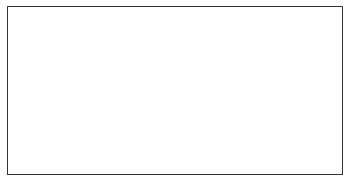

In [160]:
p = np.flip(posterior, 0)

plt.show()

plt.imshow(p, extent=[lon_w, lon_e, lat_s, lat_n])
plt.colorbar()

for ll in latlon_list:
    plt.plot(ll[0],ll[1],marker='.',color='red')

plt.plot(true_fire_loc[0], true_fire_loc[1],marker='x',color='white',markersize=12)
plt.title('Posterior of fire location, Sigma='+str(sigma)+', uniform prior')
plt.xlabel('longitude')
plt.ylabel('latitude')
